# Homework 2 - InfluxDB
Advanced Information Systems and Big Data - A.Y. 2025-2026

Dataset: Crime Data from 2020 to Present (LAPD)

In [4]:
# IMPORTS

import os
import subprocess
import time
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import json
import warnings
warnings.filterwarnings('ignore')

In [5]:
# INSTALL INFLUXDB
# - influxd: server/daemon del database
# - influx: client CLI per amministrazione
# - Porta default: 8086 (HTTP API)


# Controlla se InfluxDB è gia installato
if not os.path.exists('/usr/local/bin/influxd'): # controllo server influxd
    # Download server InfluxDB 2.7.4
    !wget -q https://download.influxdata.com/influxdb/releases/influxdb2-2.7.4_linux_amd64.tar.gz
    !tar xzf influxdb2-2.7.4_linux_amd64.tar.gz
    !cp influxdb2-2.7.4/usr/bin/influxd /usr/local/bin/
if not os.path.exists('/usr/local/bin/influx'): # controllo client influx
    # Download client CLI
    !wget -q https://dl.influxdata.com/influxdb/releases/influxdb2-client-2.7.5-linux-amd64.tar.gz
    !tar xzf influxdb2-client-2.7.5-linux-amd64.tar.gz
    !cp influx /usr/local/bin/

# Avvio server (se non già attivo)
result = subprocess.run(['pgrep', '-x', 'influxd'], capture_output=True) # pgrep: -x=cerca processo per nome esatto
if result.returncode != 0:  # returncode != 0 significa "non trovato"
    subprocess.Popen(['influxd'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL) # avvia processo in background
    time.sleep(5)

In [6]:
# SETUP INFLUXDB
# --username/--password: credenziali "admin" e "adminpassword"
# --org: organizzazione "lapd"
# --bucket: contenitore dati "crimes""
#--retention 0: nessuna scadenza automatica dei dati, default infinito

!influx setup --username admin --password adminpassword --org lapd --bucket crimes --retention 0 --force 2>/dev/null || echo "Setup gia completato"
!pip install influxdb-client -q
from influxdb_client import InfluxDBClient, Point, WritePrecision, WriteOptions

User	Organization	Bucket
admin	lapd		crimes


In [7]:
# CONFIGURATION CLIENT-INFLUXDB
# InfluxDB 2.x usa autenticazione basata su TOKEN generata al setup
token_output = !influx auth list --json # recupera token
TOKEN = json.loads(''.join(token_output))[0]['token']

URL = "http://localhost:8086"
ORG = "lapd"
BUCKET = "crimes"
# Measurement future: tabelle "crime" e "alert"

client = InfluxDBClient(url=URL, token=TOKEN, org=ORG, timeout=300000) # 5min


# API DISPONIBILI
# query_api: per eseguire query Flux (lettura)
query_api = client.query_api()

# write_api: per scrivere punti (inserimento)
write_api = client.write_api(write_options=WriteOptions(batch_size=5000, flush_interval=1000))
# batch_size=5000:
# > Accumula fino a 5000 punti in memoria
#   Poi li scrive tutti insieme in una singola richiesta HTTP
#
# flush_interval=1000:
# > Scrive comunque ogni 1000ms (1 secondo)
#   Bilancia latenza vs throughput


In [8]:
# DOWNLOAD DATASET - Crime Data LAPD
# Dataset: crimini registrati a Los Angeles dal 2020 al 2025
# Fonte: Los Angeles Open Data Portal (data.lacity.org)

df = pd.read_csv("https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD")
print(f"Record: {len(df)}")

Record: 1004991


## Parte 1: Caricamento dei Dati

In [9]:
# PREPROCESSING DEI DATI
# Il preprocessing è essenziale per la qualità delle analisi Big Data
# 1. Parsing delle date
# 2. Rimozione valori nulli o anomali
# 3. Feature engineering

In [10]:
# PARSING DATE: stringa -> datetime
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
# errors='coerce': valori non parsabili diventano NaT (Not a Time)


# RIMOZIONE VALORI NULLI O ANOMALI
df = df[
    (df['LAT'] != 0) & (df['LON'] != 0) &
    (df['DATE OCC'].notna()) &
    (df['DATE OCC'] <= '2025-11-30') &
    (df['DATE OCC'] >= '2020-01-01') &
    (df['Crm Cd'].notna()) # record senza codice crimine
].copy()
print(f"Record validi: {len(df)}")


# FEATURE ENGINEERING
df['part'] = np.where(df['Part 1-2'] == 1, 'part1', 'part2')
#   - Part 1: crimini GRAVI (omicidio, rapina, furto con scasso, etc.)
#   - Part 2: crimini MENO GRAVI (vandalismo, frode, etc.)

df['has_weapon'] = np.where(df['Weapon Used Cd'].notna(), 1, 0)
#   - Analisi uso di arma

df['hour'] = (df['TIME OCC'] // 100).astype(int) #(formato HHMM, es. 1430 = 14:30)

df['time_slot'] = np.where((df['hour'] < 6) | (df['hour'] >= 22), 'night', 'day')
#   - "night": 22:00-06:00 (ore notturne, potenzialmente più pericolose)
#   - "day": 06:00-22:00

month = df['DATE OCC'].dt.month
df['season'] = np.select(
    [month.isin([12,1,2]), month.isin([3,4,5]), month.isin([6,7,8])],
    ['winter', 'spring', 'summer'],
    default='autumn'
)

df['year'] = df['DATE OCC'].dt.year

df['district'] = df['Rpt Dist No'].fillna(0).astype(int).astype(str) #per evitare errori di parsing
df['area_id'] = df['AREA'].fillna(0).astype(int).astype(str)
df['area_name'] = df['AREA NAME'].fillna('unknown').str.replace(' ', '\\ ', regex=False)
df['vict_age'] = df['Vict Age'].fillna(0).clip(lower=0).astype(int)

Record validi: 1002751


In [11]:
# DATA MODEL INFLUXDB

def crea_point_crime(row):
    """
    Trasforma una riga del DataFrame in un Point InfluxDB.
    """
    punto = (
        Point("crime")  # Measurement name

        # ========== TAGS scelti ==========
        # Scelta di features CATEGORICHE con BASSA CARDINALITà per filtrare rapidamente
        .tag("district", str(row['district']))
        .tag("area_id", str(row['area_id']))
        .tag("area_name", str(row['AREA NAME']).replace(' ', '_'))
        .tag("part", row['part'])                     # Violento o no
        .tag("has_weapon", str(row['has_weapon']))    # Arma o no
        .tag("time_slot", row['time_slot'])           # "day" o "night"
        .tag("season", row['season'])

        # ========== FIELDS scelti ==========
        # Scelta di features NUMERICHE o TESTUALI con ALTA CARDINALITà
        .field("crm_cd", int(row['Crm Cd']))
        .field("vict_age", int(row['vict_age']))
        .field("lat", float(row['LAT']))
        .field("lon", float(row['LON']))
        .field("count", 1)  # ogni crimine conta 1

        # ========== TIMESTAMP ==========
        # Indice temporale primario
        .time(row['DATE OCC'], WritePrecision.NS)     # Nanosecond precision
    )
    return punto


# BATCH LOADING
batch_size = 10000
# Cchiamata API tramite "with" x garanzia chiusura corretta
with client.write_api(write_options=WriteOptions(batch_size=5000, flush_interval=1000)) as write_api:
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]  # Slice del DataFrame
        points = [crea_point_crime(row) for _, row in batch.iterrows()]
        write_api.write(bucket=BUCKET, org=ORG, record=points)

### Alert

In [12]:
# SISTEMA DI ALERTING

# Calcolo statistiche giornaliere per definire la baseline
daily_stats = df.groupby(df['DATE OCC'].dt.date).agg({
    'DR_NO': 'count',                           # Totale crimini/giorno
    'part': lambda x: (x == 'part1').sum(),     # Crimini violenti/giorno
    'has_weapon': 'mean'                         # % con arma/giorno
}).rename(columns={'DR_NO': 'total', 'part': 'violent', 'has_weapon': 'weapon_pct'})

# Calcolo soglie come percentuale del massimo storico
SOGLIE = {
    'daily_warning': int(daily_stats['total'].max() * 0.05),     # 5% del max
    'daily_alarm': int(daily_stats['total'].max() * 0.10),       # 10% del max

    'violent_warning': int(daily_stats['violent'].max() * 0.05),  # 5% del max
    'violent_alarm': int(daily_stats['violent'].max() * 0.10),    # 10% del max

    'weapon_warning': daily_stats['weapon_pct'].max() * 0.05,  # 5% del max
    'weapon_alarm': daily_stats['weapon_pct'].max() * 0.10     # 10% del max
}

print("Soglie configurate:")
for k, v in SOGLIE.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

Soglie configurate:
  daily_alarm: 116
  violent_alarm: 66
  weapon_alarm: 0.1000


In [13]:
# Genera alert per giorni che superano le soglie
all_alerts = [] # struttura: data-tipo-livelloAllerta-valore

for data, row in daily_stats.iterrows():
    if row['total'] >= SOGLIE['daily_alarm']:
        all_alerts.append((data, 'daily', 'alarm', row['total']))
    elif row['total'] >= SOGLIE['daily_warning']:
        all_alerts.append((data, 'daily', 'warning', row['total']))

    if row['violent'] >= SOGLIE['violent_alarm']:
        all_alerts.append((data, 'violent', 'alarm', row['violent']))
    elif row['violent'] >= SOGLIE['violent_warning']:
        all_alerts.append((data, 'violent', 'warning', row['violent']))

    if row['weapon_pct'] >= SOGLIE['weapon_alarm']:
        all_alerts.append((data, 'weapon_pct', 'alarm', row['weapon_pct']))
    elif row['weapon_pct'] >= SOGLIE['weapon_warning']:
        all_alerts.append((data, 'weapon_pct', 'warning', row['weapon_pct']))

print(f"Alert generati: {len(all_alerts)} (Warning: {len([a for a in all_alerts if a[2]=='warning'])}, Alarm: {len([a for a in all_alerts if a[2]=='alarm'])})")

Alert generati: 5340 (Warning: 84, Alarm: 5256)


In [14]:
# PERSISTENZA ALERT SU INFLUXDB
# Salvo gli alert come MEASUREMENT SEPARATO ("alert" vs "crime")
# - Query indipendenti e mirate(non mischio crimini e alert)
# - Retention policy diverse (alert per sempre nel db)

# Chiamata API tramite "with" x garanzia chiusura corretta
with client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=1000)) as wa:
    for data, tipo, livello, valore in all_alerts:
        punto = (
            Point("alert")
            .tag("type", tipo)            # Tipo di alert
            .tag("level", livello)        # Gravità
            .field("value", float(valore))
            .time(pd.Timestamp(data))
        )
        wa.write(bucket=BUCKET, org=ORG, record=punto)

### Simulazione del Conteggio

In [15]:
# QUERY FLUX - Conteggio per Categoria (Part 1 vs Part 2)

print("Conteggi per part:")
result_part = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["part"])
  |> count()
''')
# Seleziona dati dal 2020, "crime" e field=count
#  Raggruppa i dati per il tag "part"
#  Crea gruppi separati per part1 e part2
#  Conta le dimensioni e metti in "_value"


for table in result_part: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f" {r.values.get('part')}: {r.get_value()}") # r Flux Object

Conteggi per part:
 part1: 520349
 part2: 355787


In [16]:
# QUERY FLUX - Conteggio per Presenza Arma

print("Conteggi per arma:")
result_weapon = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["has_weapon"])
  |> count()
''')
# Seleziona dati dal 2020, "crime" e field=count
#  Raggruppa i dati per il tag "has_weapon"
#  Crea gruppi separati per 0 e 1
#  Conta le dimensioni e metti in "_value"


for table in result_weapon: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f"  arma_{r.values.get('has_weapon')}: {r.get_value()}") # r Flux Object

Conteggi per arma:
  arma_0: 591224
  arma_1: 284912


In [17]:
# QUERY FLUX - Top 10 Aree per Numero di Crimini

print("Top 10 aree per crimini:")
result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["area_name"])
  |> count()
  |> sort(columns: ["_value"], desc: true)
  |> limit(n: 10)
''')
# Seleziona dati dal 2020, "crime" e field=count
#  Raggruppa i dati per "area_name"
#  Crea gruppi separati per le diverse aree
#  Conta le dimensioni e metti in "_value"
#  Ordina e prende solo i primi 10


for table in result: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f"  {r.values.get('area_name')}: {r.get_value()}") # r Flux Object

Top 10 aree per crimini:
  77th_Street: 53038
  Central: 56463
  Devonshire: 37061
  Foothill: 30134
  Harbor: 36733
  Hollenbeck: 33337
  Hollywood: 44243
  Mission: 36331
  N_Hollywood: 45135
  Newton: 43064
  Northeast: 38725
  Olympic: 44725
  Pacific: 51501
  Rampart: 40562
  Southeast: 42719
  Southwest: 49729
  Topanga: 35518
  Van_Nuys: 37658
  West_LA: 40234
  West_Valley: 37769
  Wilshire: 41457


## Part 2: Interrogazioni Analitiche

### Query 1: Media giornaliera per area e stagione

In [18]:
# QUERY 1: Media Giornaliera Crimini per Area e Stagione

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["area_name", "season"])
  |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
  |> mean()
''')
# Seleziona crimini dal 2020, "crime" e field=count
# Raggruppa per (area, stagione)
# Per ogni gruppo, somma per giorno i valori di "count" (1 per tutte le righe)
# Per ogni gruppo, calcola media delle somme giornaliere (in _value)

t_global = time.time() - t0

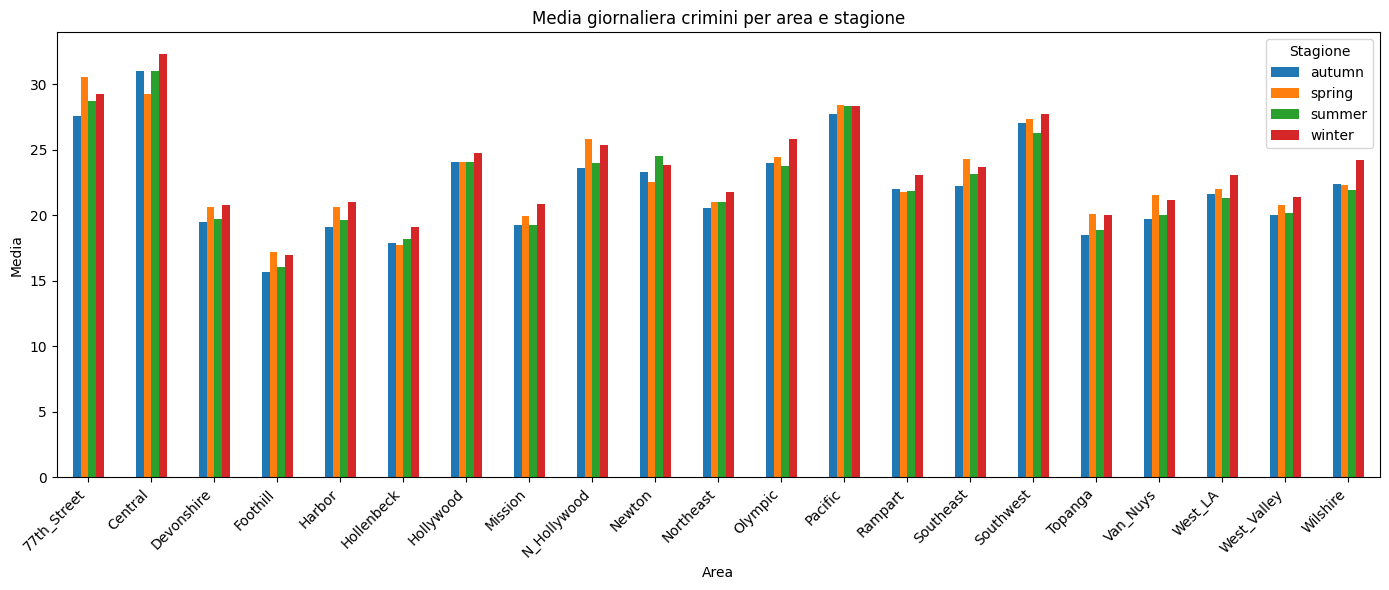


Picchi stagionali:
  77th_Street: spring
  Central: winter
  Devonshire: winter
  Foothill: spring
  Harbor: winter
  Hollenbeck: winter
  Hollywood: winter
  Mission: winter
  N_Hollywood: spring
  Newton: summer
  Northeast: winter
  Olympic: winter
  Pacific: spring
  Rampart: winter
  Southeast: spring
  Southwest: winter
  Topanga: spring
  Van_Nuys: spring
  West_LA: winter
  West_Valley: winter
  Wilshire: winter


In [19]:
data = []
for table in result:
    for r in table.records:
        data.append({
            'area': r.values.get('area_name'),
            'season': r.values.get('season'),
            'avg': r.get_value()
        })
# Pivot per visualizzazione (righe=aree, colonne=stagioni)
df_q1 = pd.DataFrame(data)
pivot = df_q1.pivot(index='area', columns='season', values='avg').fillna(0)
pivot.plot(kind='bar', figsize=(14, 6))
plt.title('Media giornaliera crimini per area e stagione')
plt.xlabel('Area')
plt.ylabel('Media')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stagione')
plt.tight_layout()
plt.show()

print("\nPicchi stagionali:")
for area in pivot.index:
    peak = pivot.loc[area].idxmax()  # Stagione con media più alta
    print(f"  {area}: {peak}")

In [20]:
# BENCHMARK: Query Globale vs Query Filtrata

print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.season == "{season}")
      |> group(columns: ["area_name"])
      |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
      |> mean()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    elapsed = time.time() - t0
    print(f"{season}: {elapsed:.2f}s")

Tempo query globale: 91.19s

Tempo query per stagione
winter: 30.27s
spring: 23.67s
summer: 31.37s
autumn: 22.61s


### Query 2: Distribuzione part 1-2 per fascia oraria (mese: Luglio 2023)

In [21]:
# QUERY 2: Distribuzione per Categoria e Fascia Oraria (Luglio 2023)

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2023-07-01T00:00:00Z, stop: 2023-08-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["part", "time_slot"])
  |> count()
''')
# Seleziona crimini di Luglio 2023, "crime" e field=count
# Raggruppa per (part, time_slot)
# Per ogni gruppo, calcola somme di count (in _value)

t_global = time.time() - t0

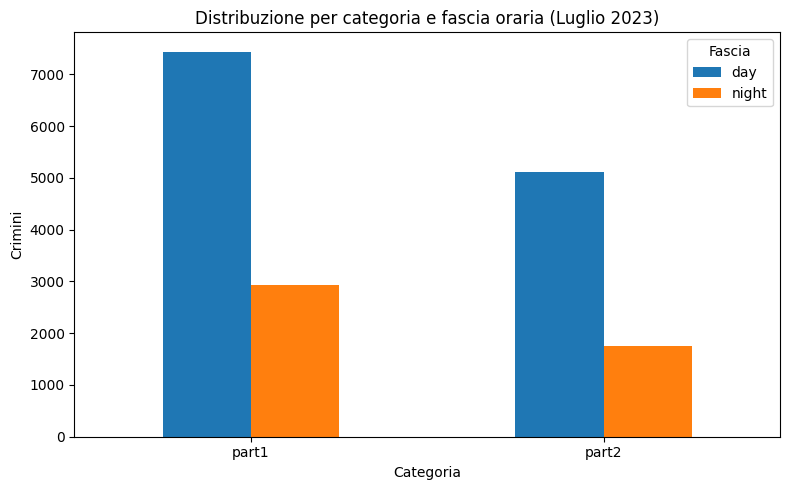


Analisi:
  part1: giorno 71.7%, notte 28.3%
  part2: giorno 74.4%, notte 25.6%


In [22]:
data = []
for table in result:
    for r in table.records:
        data.append({
            'part': r.values.get('part'),
            'time_slot': r.values.get('time_slot'),
            'count': r.get_value()
        })

df_q2 = pd.DataFrame(data)
pivot2 = df_q2.pivot(index='part', columns='time_slot', values='count').fillna(0)
pivot2.plot(kind='bar', figsize=(8, 5))
plt.title('Distribuzione per categoria e fascia oraria (Luglio 2023)')
plt.xlabel('Categoria')
plt.ylabel('Crimini')
plt.xticks(rotation=0)
plt.legend(title='Fascia')
plt.tight_layout()
plt.show()

# Calcolo percentuali giorno/notte per ogni categoria
print("\nAnalisi:")
for p in pivot2.index:
    tot = pivot2.loc[p].sum()
    print(f"  {p}: giorno {pivot2.loc[p,'day']/tot*100:.1f}%, notte {pivot2.loc[p,'night']/tot*100:.1f}%")

In [23]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2023-07-01T00:00:00Z, stop: 2023-08-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.season == "{season}")
      |> group(columns: ["part", "time_slot"])
      |> count()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 0.33s

Tempo query per stagione
winter: 0.02s
spring: 0.01s
summer: 0.34s
autumn: 0.01s


### Query 3: Giornata con piu crimini violenti per area

In [24]:
# QUERY 3: Giornata con Più Crimini Violenti per Area

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> filter(fn: (r) => r.part == "part1")
  |> group(columns: ["area_name"])
  |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
  |> max()
''')
# Seleziona crimini dal 2020, "crime" e field=count
# Filtra per tag = arma)part1)
# Raggruppa per "area_name"
# Per ogni area_name, somma per giorno i valori di "count" (1 per tutte le righe)
# Per ogni area_name, ritorna il max (in _value)

t_global = time.time() - t0

In [25]:
print("\nTabella:")
print(f"{'Area':<20} {'Data':<12} {'Mese':<12} {'Conteggio'}")
print("-" * 55)

mesi = []
for table in result:
    for r in table.records:
        area = r.values.get('area_name')
        data = r.get_time().strftime('%Y-%m-%d') # timestamp del FluxObject
        mese = r.get_time().strftime('%B')# timestamp del FluxObject
        mesi.append(mese)
        print(f"{area:<20} {data:<12} {mese:<12} {r.get_value()}")

# Analisi distribuzione mesi dei picchi
print("\nConcentrazione per mese:")
for m, c in pd.Series(mesi).value_counts().items():
    print(f"  {m}: {c}")


Tabella:
Area                 Data         Mese         Conteggio
-------------------------------------------------------
77th_Street          2020-06-02   June         30
Central              2020-05-30   May          47
Devonshire           2021-11-06   November     25
Foothill             2021-09-25   September    22
Harbor               2023-12-23   December     26
Hollenbeck           2023-07-13   July         25
Hollywood            2021-10-31   October      32
Mission              2022-02-16   February     27
N_Hollywood          2021-10-10   October      30
Newton               2023-09-02   September    33
Northeast            2021-07-24   July         28
Olympic              2023-11-25   November     31
Pacific              2021-05-13   May          34
Rampart              2021-08-21   August       28
Southeast            2022-01-02   January      30
Southwest            2021-09-13   September    32
Topanga              2020-06-26   June         24
Van_Nuys             2020-0

In [26]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.part == "part1" and r.season == "{season}")
      |> group(columns: ["area_name"])
      |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
      |> max()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 76.23s

Tempo query per stagione
winter: 11.77s
spring: 11.78s
summer: 12.23s
autumn: 11.14s


### Query 4: Età media vittime

In [27]:
# QUERY 4: Età Media Vittime per Year e Categoria

t0 = time.time()

result = query_api.query("""
import "date"
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) =>
      r._measurement == "crime" and
      r._field == "vict_age" and
      r._value > 0
  )
  |> map(fn: (r) => ({ r with year: date.year(t: r._time) }))
  |> group(columns: ["year", "part"])
  |> mean()
""")
# Seleziona crimini dal 2020, "crime" e field=vict_age (con _value>0 =miss val)
# Filtra per tag = arma)part1)
# Crea un nuovo record con i dati attuali + year (date.year(t: r._time): estrae l'anno dal timestamp)
# Raggruppa per "year" e "part"
# Per ogni gruppo, ritorna la media valori (in _value)

t_global = time.time() - t0


Eta media:
part  part1  part2
year              
2020   39.9   39.7
2021   39.7   39.8
2022   39.8   39.6
2023   40.1   39.7
2024   38.9   39.8
2025   24.1   22.0


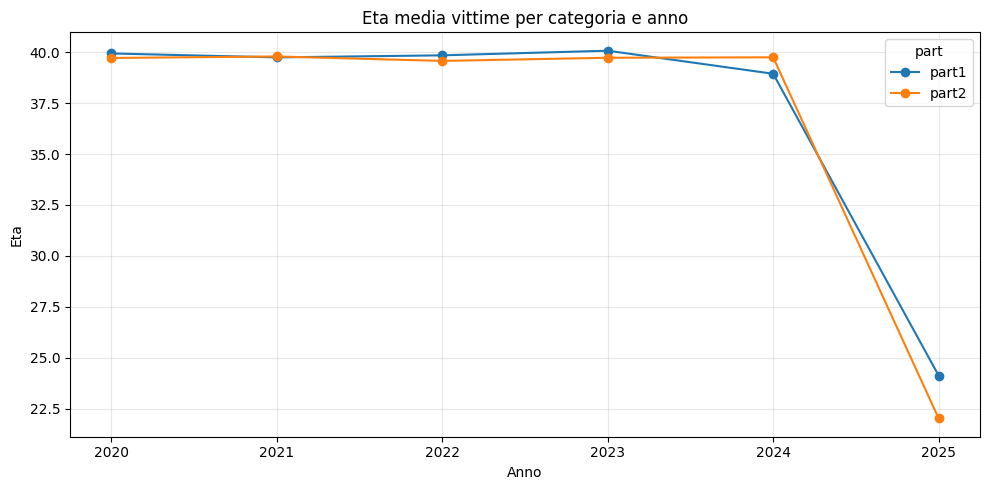

In [28]:
data = [{'year': int(r.values.get('year')), 'part': r.values.get('part'), 'avg': r.get_value()}
        for table in result for r in table.records]

pivot_eta = pd.DataFrame(data).pivot(index='year', columns='part', values='avg')
print("\nEta media:")
print(pivot_eta.round(1))
pivot_eta.plot(kind='line', marker='o', figsize=(10, 5))
plt.title('Eta media vittime per categoria e anno')
plt.xlabel('Year')
plt.ylabel('Eta')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
import "date"
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "vict_age")
      |> filter(fn: (r) => r.vict_age > 0 and r.season == "{season}")
      |> map(fn: (r) => ({{ r with year: date.truncate(t: r._time, unit: 1y) }}))
      |> group(columns: ["part", "year"])
      |> mean()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 264.17s

Tempo query per stagione
winter: 27.73s
spring: 35.48s
summer: 31.70s
autumn: 33.10s


## Part 3: Clustering Incrementale

### Clustering Incrementale

Clustering con MiniBatchKMeans e `partial_fit()` per aggiornamento incrementale.

*   Variabili: n_crimes, pct_weapon, pct_night, pct_violent.

*   Aggregazione: area, stagione, anno.

In [93]:
# AGGREGAZIONE DATI PER CLUSTERING
features = ['n_crimes', 'pct_weapon', 'pct_violent', 'pct_night']
aggregates = ['area', 'season', 'year']

agg = df.groupby(['AREA NAME', 'season', 'year']).agg({
    'DR_NO': 'count',                              # Num crimini
    'has_weapon': 'mean',                          # % uso arma  (essendo binario è %)
    'part': lambda x: (x == 'part1').mean(),       # % violenti  (essendo binario è %)
    'time_slot': lambda x: (x == 'night').mean()   # % notte     (essendo binario è %)
}).reset_index()
agg.columns = aggregates + features

print(f"Record aggregati: {len(agg)}")

Record aggregati: 449


In [94]:
# CLUSTERING INCREMENTALE CON MiniBatchKMeans

def clustering_incrementale(df, features, n_clusters=2):
    df = df.copy()

    # NORMALIZZAZIONE
    scaler = StandardScaler()
    # StandardScaler: trasforma ogni feature in media=0, std=1
    X = scaler.fit_transform(df[features])

    # MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=50)

    # Clustering incrementale: un anno alla volta
    for year in sorted(df['year'].unique()):
        mask = df['year'] == year # per filtrare il dataframe
        kmeans.partial_fit(X[mask])
        # Assegna cluster ai punti dell'anno corrente
        df.loc[mask, 'cluster'] = kmeans.predict(X[mask])

        # Mostra distribuzione cluster per questo anno
        print(f"{year}: {np.bincount(df.loc[mask, 'cluster'].astype(int), minlength=n_clusters)}")

    return df, kmeans

In [95]:
# Esecuzione clustering
agg, kmeans = clustering_incrementale(agg, features)
agg.groupby(['year', 'cluster'])[features].mean().round(3)

2020: [57 27]
2021: [55 29]
2022: [52 32]
2023: [50 34]
2024: [80  4]
2025: [25  4]


n_crimes  pct_weapon  pct_violent  pct_night
year cluster                                              
2020 0.0      2199.175       0.314        0.583      0.233
     1.0      2729.741       0.452        0.576      0.260
2021 0.0      2291.364       0.299        0.588      0.240
     1.0      2841.621       0.437        0.590      0.257
2022 0.0      2493.115       0.284        0.573      0.242
     1.0      3300.500       0.392        0.573      0.268
2023 0.0      2458.260       0.292        0.594      0.229
     1.0      3218.471       0.398        0.606      0.256
2024 0.0      1472.212       0.138        0.716      0.227
     1.0      2447.500       0.411        0.606      0.257
2025 0.0         3.600       0.182        0.290      0.116
     1.0         1.750       1.000        0.000      0.000

In [96]:
# ANALYSIS EVOLUZIONE TEMPORALE DEI CLUSTER
# Confronto l'assegnazione ai cluster tra 2020 e 2024
# per identificare aree che hanno cambiato "profilo criminale"

# estrazione cluster per ogni area nel 2020 e 2024
c2020 = agg[agg['year'] == 2020].groupby('area')['cluster'].first()
c2024 = agg[agg['year'] == 2024].groupby('area')['cluster'].first()

comp = pd.DataFrame({'2020': c2020, '2024': c2024}).dropna()
changed = comp[comp['2020'] != comp['2024']] # aree dove il cluster è cambiato

print(f"Aree cambiate: {len(changed)} su {len(comp)}")
if len(changed) > 0:
    print("\nDettaglio:")
    for area, row in changed.iterrows():
        print(f"  {area}: {int(row['2020'])} -> {int(row['2024'])}")

Aree cambiate: 7 su 21

Dettaglio:
  77th Street: 1 -> 0
  Central: 1 -> 0
  Hollywood: 1 -> 0
  Newton: 1 -> 0
  Olympic: 1 -> 0
  Southeast: 1 -> 0
  Southwest: 1 -> 0


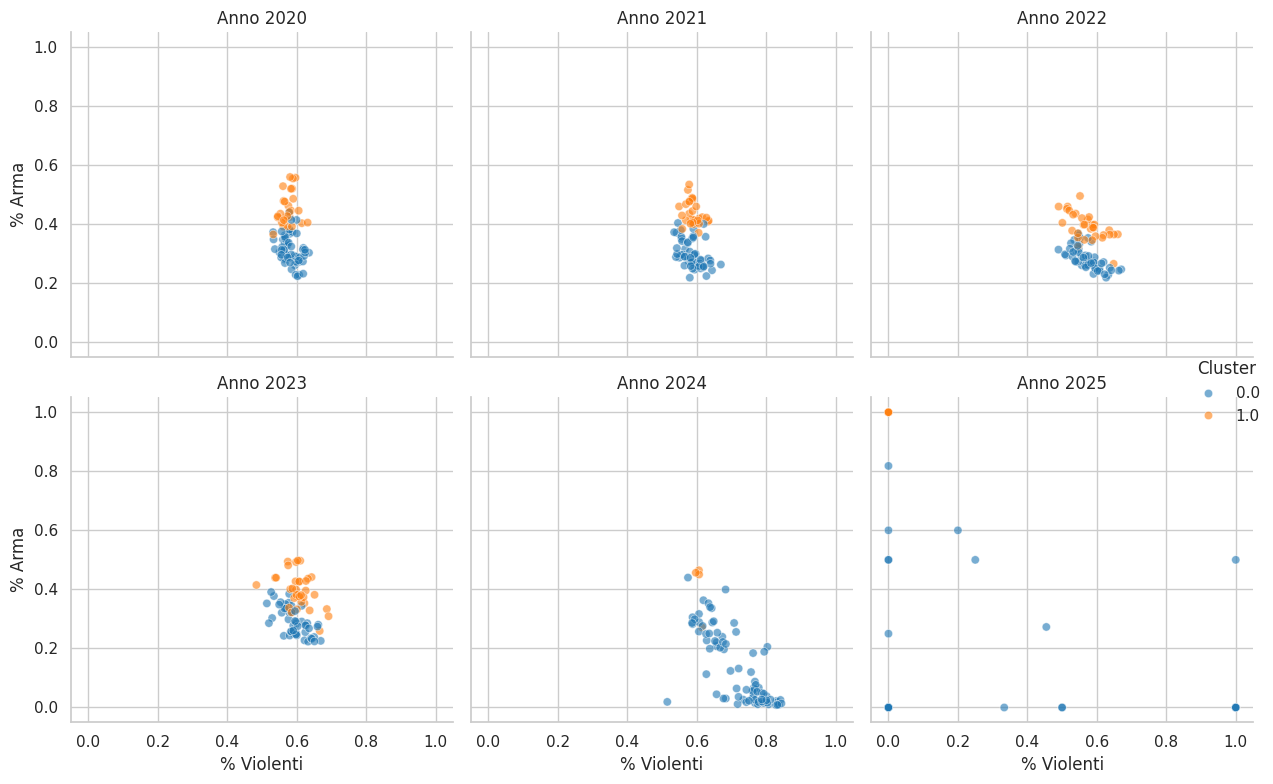


CLUSTER 0 — Criminalità poco armata, molto violenta, diurna
CLUSTER 1 — Criminalità molto armata, poco violenta, notturna



In [102]:
# VISUALIZATION

agg['year'] = agg['year'].astype(str)

sns.set(style="whitegrid")
g = sns.FacetGrid(agg, col="year", col_wrap=3, height=4, sharex=True, sharey=True) #one chart per year
g.map_dataframe(sns.scatterplot, x='pct_violent', y='pct_weapon', hue='cluster', palette={0: "#1f77b4", 1: "#ff7f0e"}, alpha=0.6)
g.add_legend(title='Cluster')
g.set_axis_labels('% Violent', '% Weapon')
g.set_titles('Year {col_name}')
plt.tight_layout()
plt.show()

print(
    "\nCLUSTER 0 — Low weapon usage, highly violent, daytime crime\n"
    "CLUSTER 1 — High weapon usage, less violent, nighttime crime\n"
)